<a href="https://colab.research.google.com/github/erenakbay/Brain_Tumor_Dedector/blob/main/brainProje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Project Name: Detecting Brain Tumors from MRI's
# This project is about identifying brain tumors from MRI's. Accurate detection is crucial for doctors and this
# model is easy to use as it is automated and can detect by just feeding raw images of MRI's. My model achieves a high
# rate of accuracy and is robust to minor changes in images.

# Link to dataset: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset?resource=download
# Dataset has 4 categories: Glioma, Meningioma, No Tumor, and Pituitary

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import random
import datetime
import cv2
import os
import io
from PIL import Image

glioma: 1621 images
meningioma: 1645 images
notumor: 2000 images
pituitary: 1757 images


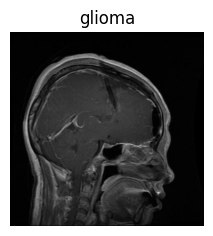

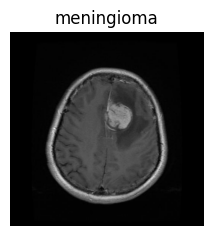

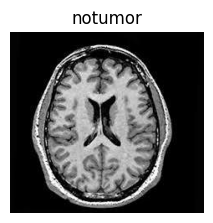

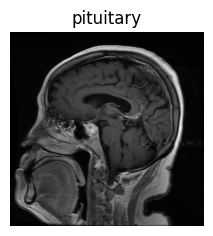

In [ ]:
# Exploratory Data Analysis (EDA)
imagesData = '/content/drive/MyDrive/brainData/images'
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_counts = {}

for label in labels:
    folderPath = os.path.join(imagesData, label)
    files_list = os.listdir(folderPath)
    number_of_files = len([file for file in files_list if os.path.isfile(os.path.join(folderPath, file))])
    class_counts[label] = number_of_files
    print(f'{label}: {number_of_files} images')

#displaying images
def displayImages(images, labels):
    numImages = len(images)
    plt.figure(figsize=(numImages * 2.5, 3))
    for i in range(numImages):
        plt.subplot(1, numImages, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

#we will only display one image from each category
oneImagetoDisplay = 1
for label in labels:
    folderPath = os.path.join(imagesData, label)
    images_to_show = random.sample(os.listdir(folderPath), oneImagetoDisplay)
    displayImages([np.array(Image.open(os.path.join(folderPath, image)).convert('L')) for image in images_to_show],
                   [label])

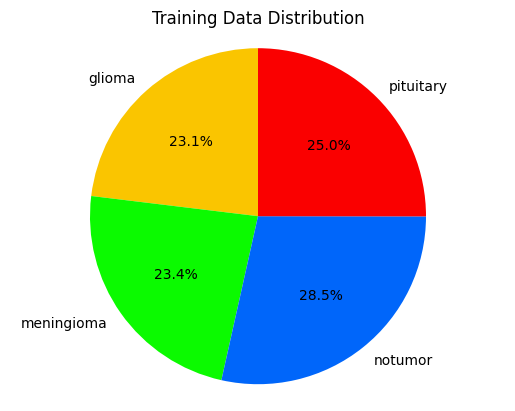

In [ ]:
fig, ax = plt.subplots()
ax.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', startangle=90, colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'])
ax.axis('equal')
plt.title('Training Data Distribution')
plt.show()

In [ ]:
# Data Preprocessing
labels = ['glioma', 'meningioma', 'notumor', 'pituitary'] #there are 4 categories in the dataset
imageSize = 100 #we decided to use this image size as we got the best results

x = [] #we are storing the images
y = [] #we are storing the labels of the iamges

images = '/content/drive/MyDrive/brainData/images'

for label in labels:
    folderPath = os.path.join(images, label)
    for file in tqdm(os.listdir(folderPath)):
        image_path = os.path.join(folderPath, file)
        image = Image.open(image_path).convert('L')  # I am converting to grayscale with the PIL
        image = image.resize((imageSize, imageSize)) # I am resizing the images so they are all the same
        image = np.array(image) # im converting the image to numpy arrays
        x.append(image)
        y.append(labels.index(label))

# I am converting lists to NumPy arrays and normalizing them
x = np.array(x) / 255.0  # normalizing the images
y = np.array(y)

# the train-test split: 80% training, 20% testing
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)
xTrain, yTrain = shuffle(xTrain, yTrain, random_state=42) #we are shuffling to prevent overfitting
yTrain = tf.keras.utils.to_categorical(yTrain, num_classes=len(labels))
yTest = tf.keras.utils.to_categorical(yTest, num_classes=len(labels))

# the validaiton split
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size=0.1, random_state=42)

# printing out the shapes
print(f'Training set shape: {xTrain.shape}')
print(f'Validation set shape: {xVal.shape}')
print(f'Testing set shape: {xTest.shape}')

100%|██████████| 1757/1757 [00:55<00:00, 31.56it/s]


Training set shape: (5056, 100, 100)
Validation set shape: (562, 100, 100)
Testing set shape: (1405, 100, 100)


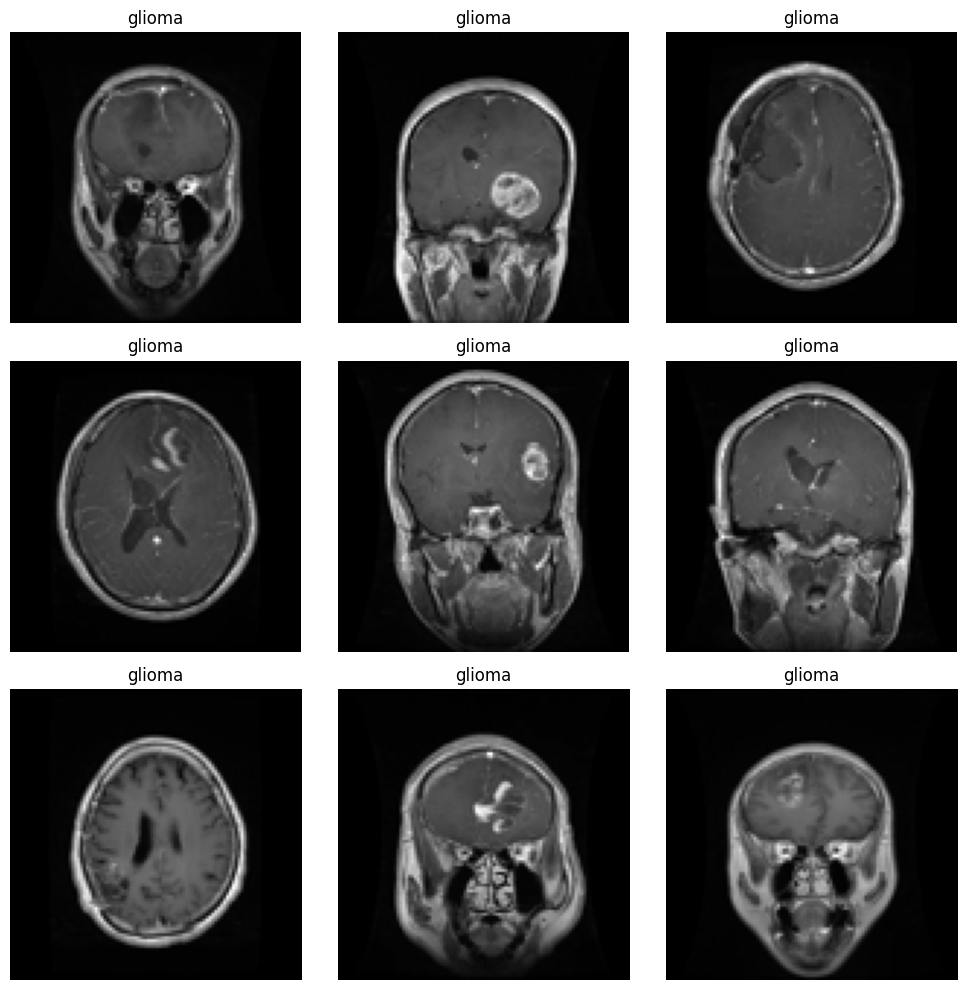

In [ ]:
#displaying the images after preprocessing to make sure it looks okay
def display_sample_images(data, labels, class_labels):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(data[i], cmap='gray')
        plt.title(class_labels[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
display_sample_images(x, y, labels)

In [ ]:
# Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#we played around with the values to our liking and experimentation
datagen = ImageDataGenerator(
    rotation_range=20, #randomly rotates images in the range 0 to 20 degrees
    width_shift_range=0.1, #randomly shifts images horizontally by up to 10% of the image width
    height_shift_range=0.1,  #randomly shift images vertically by up to 10% of the image height.
    shear_range=0.1, #randomly applies shearing transformations up to 10%
    zoom_range=0.1, #randomly zooms into the images up to 10%
    horizontal_flip=True, #flips image horizontal way
    vertical_flip=True, #flips image verticcaly
    fill_mode='nearest'  #specifies how to fill in newly created pixels:'Nearest' means use the value of the nearest pixel
)
xTrain_reshaped = xTrain.reshape((-1, 100, 100, 1))
datagen.fit(xTrain_reshaped)

In [ ]:
from kerastuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential([
        Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
               kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
               activation='relu',
               input_shape=(100, 100, 1)),
        MaxPooling2D(2, 2),
        Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
               kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
               activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
              activation='relu'),
        Dense(4, activation='softmax')
    ])

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=5,
                     directory='output',
                     project_name='BrainMRIHyperTuning')

tuner.search(xTrain, yTrain, epochs=3, validation_data=(xVal, yVal))
#optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# best model is trained
model = tuner.hypermodel.build(best_hps)
history = model.fit(xTrain, yTrain, epochs=10, validation_data=(xVal, yVal))

ModuleNotFoundError: No module named 'kerastuner'

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 22, 22, 64)        0

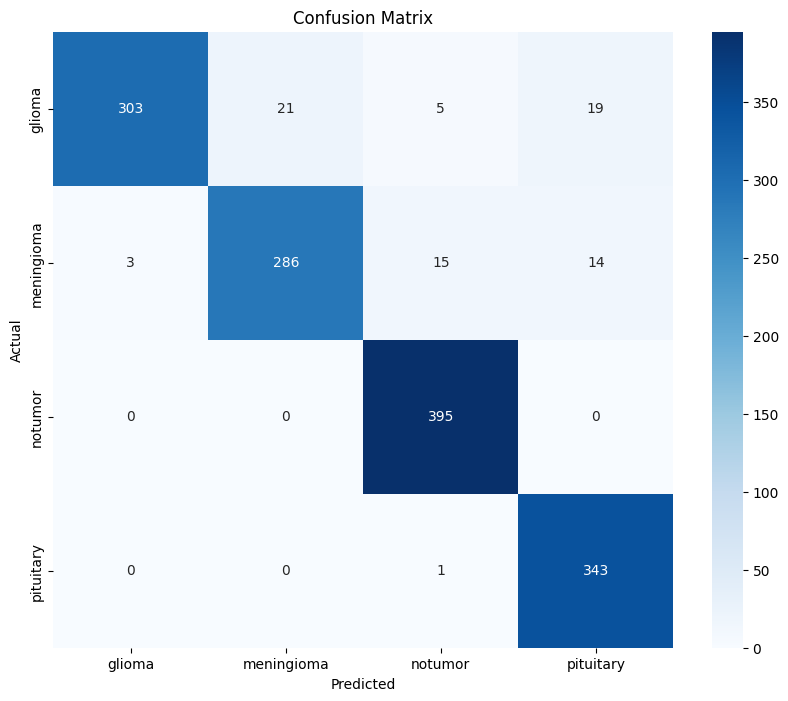

              precision    recall  f1-score   support

      glioma       0.99      0.87      0.93       348
  meningioma       0.93      0.90      0.92       318
     notumor       0.95      1.00      0.97       395
   pituitary       0.91      1.00      0.95       344

    accuracy                           0.94      1405
   macro avg       0.95      0.94      0.94      1405
weighted avg       0.95      0.94      0.94      1405



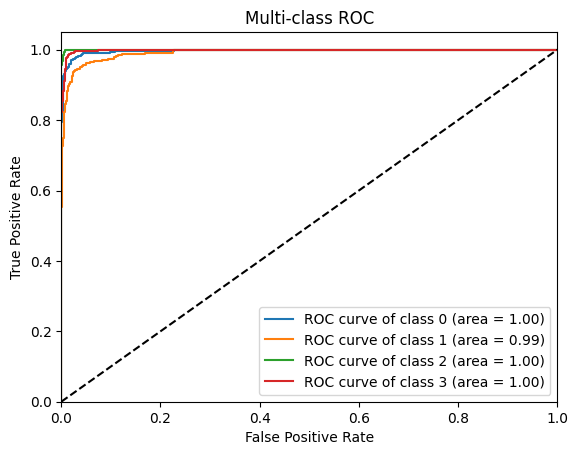

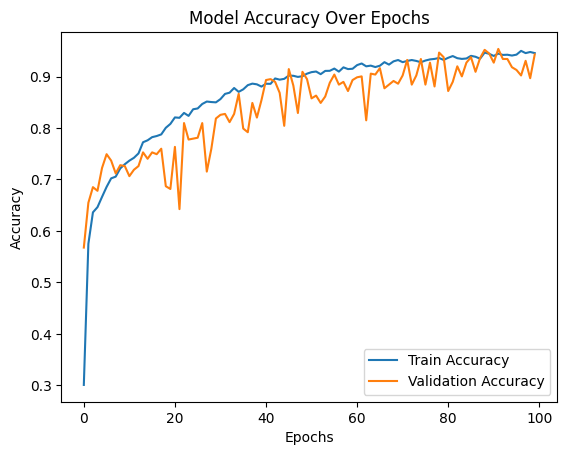

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

model = Sequential([
    Conv2D(64, (5, 5), activation='relu', input_shape=(100, 100, 1)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(64, (5, 5), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(128, (4, 4), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(128, (4, 4), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.5),
    Flatten(),
    Dense(512, activation="relu"),
    Dense(4, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(datagen.flow(xTrain_reshaped, yTrain, batch_size=32),
                    validation_data=(xVal.reshape(-1, 100, 100, 1), yVal),
                    epochs=100,
                    verbose=1)
test_loss, test_acc = model.evaluate(xTest.reshape(-1, 100, 100, 1), yTest, verbose=2)
print(f"Test Accuracy: {test_acc*100:.2f}%")

#probabilities for the test set
predictionsProb = model.predict(xTest.reshape(-1, 100, 100, 1))
#probabilities to class predictions
predictions = np.argmax(predictionsProb, axis=1)
#yTest is one-hot encoded, convert it back to class indices for comparison
trueLabels = np.argmax(yTest, axis=1)

#confusion matrix
confMatr = confusion_matrix(trueLabels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(confMatr, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

#summary of results
print(classification_report(trueLabels, predictions, target_names=labels))

from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

y_test_binarized = to_categorical(trueLabels)

#roc calcualtions
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictionsProb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#the figures for roc
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()

#accuracy graph
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       139
           1       0.74      0.74      0.74       134
           2       0.96      0.92      0.94       155
           3       0.92      0.97      0.94       134

    accuracy                           0.86       562
   macro avg       0.86      0.86      0.86       562
weighted avg       0.86      0.86      0.86       562



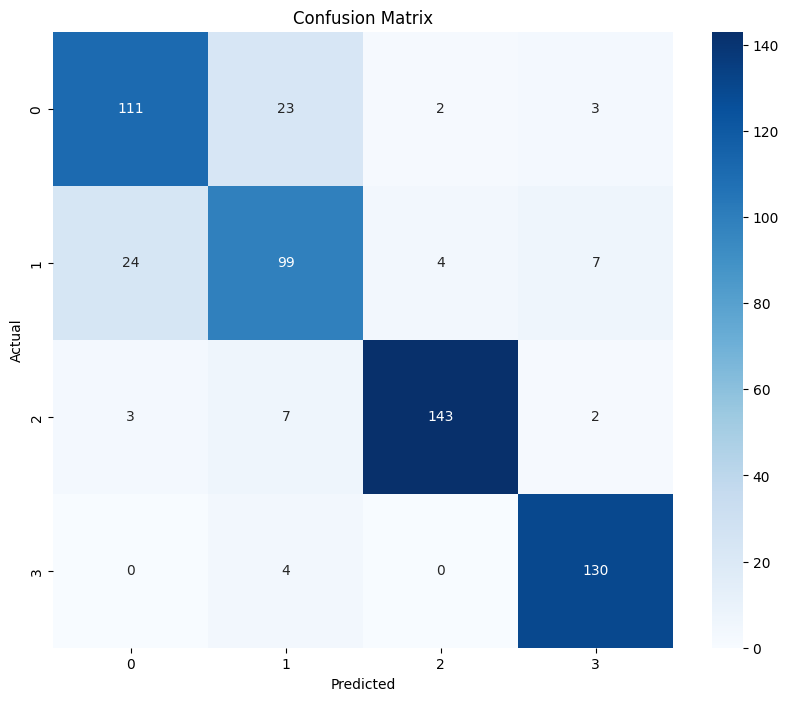

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# we have to flatten the data for the SVM
xTrainFlat = xTrain.reshape((xTrain.shape[0], -1))
xValFlat = xVal.reshape((xVal.shape[0], -1))

# SVM model
svm = SVC(kernel='linear', C=1.0)
svm.fit(xTrainFlat, np.argmax(yTrain, axis=1))

# predicting the labels in validaiton set
predictions = svm.predict(xValFlat)

# calculating the confusion matrix
confMat = confusion_matrix(np.argmax(yVal, axis=1), predictions)

# classification summary
print(classification_report(np.argmax(yVal, axis=1), predictions))

# Confusion matrix display
plt.figure(figsize=(10, 8))
sns.heatmap(confMat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Cross-Validation Accuracies: [0.88735178 0.85855589 0.87141444 0.8892186  0.8793274 ]
Mean Accuracy: 0.88 ± 0.02


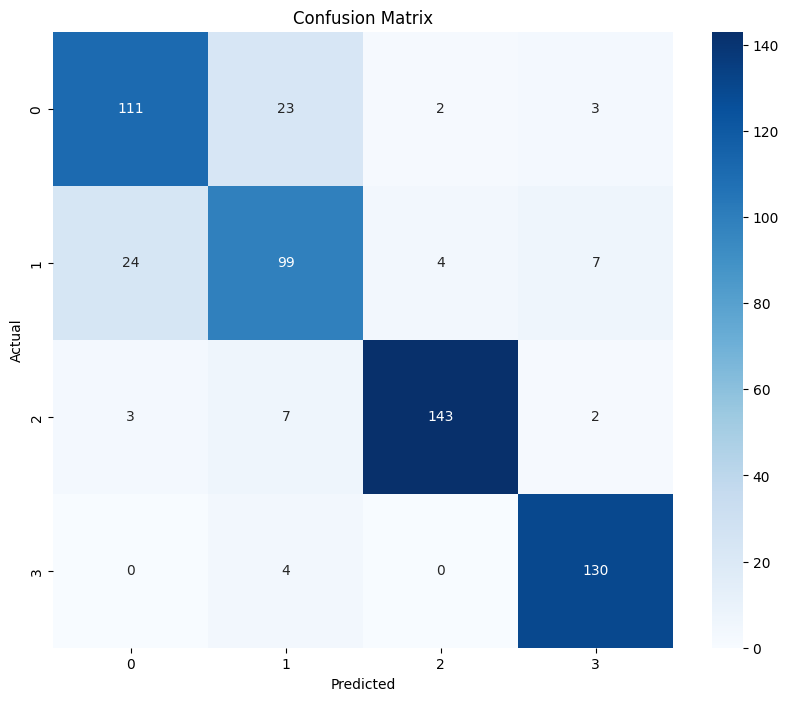

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       139
           1       0.74      0.74      0.74       134
           2       0.96      0.92      0.94       155
           3       0.92      0.97      0.94       134

    accuracy                           0.86       562
   macro avg       0.86      0.86      0.86       562
weighted avg       0.86      0.86      0.86       562



In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

#we performed k-fold cross validation for our SVM model
#we included the original SVM model in the upper cell just in case

xTrain_flat = xTrain.reshape((xTrain.shape[0], -1))  #Flattening
xVal_flat = xVal.reshape((xVal.shape[0], -1))
yTrain_indices = np.argmax(yTrain, axis=1)           #Converting one-hot labels to indices
yVal_indices = np.argmax(yVal, axis=1)

#k-fold cross validation
svm_model = SVC(kernel='linear', C=1.0)
scores = cross_val_score(svm_model, xTrain_flat, yTrain_indices, cv=5)
print(f"Cross-Validation Accuracies: {scores}")
print(f"Mean Accuracy: {np.mean(scores):.2f} ± {np.std(scores)*2:.2f}")

#Training the final model on all training data
svm_model.fit(xTrain_flat, yTrain_indices)

#Predicting on the validation set and computing the confusion matrix
predictions = svm_model.predict(xVal_flat)
confMat = confusion_matrix(yVal_indices, predictions)

#show the confusin matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confMat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

#this is the classification summary
print(classification_report(yVal_indices, predictions))

In [ ]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00
